In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy
import tinyarray
import argparse
from scipy import linalg as la
from scipy.sparse import linalg as sla
from types import SimpleNamespace
from copy import deepcopy
from utils2 import Regular_Polygon

In [2]:
lat = kwant.lattice.honeycomb(a=1.0, norbs=1)
a_lat, b_lat = lat.sublattices

nnn_hoppings_a = (((-1, 0), a_lat, a_lat), ((0, 1), a_lat, a_lat), ((1, -1), a_lat, a_lat))
nnn_hoppings_b = (((1, 0), b_lat, b_lat), ((0, -1), b_lat, b_lat), ((-1, 1), b_lat, b_lat))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

def make_system(a, shape="ribbon", diminsions=SimpleNamespace(L=10, W=10)):

    def onsite(site, param):
        staggered_pot =  param.m if site.family == a_lat else -param.m
        disorder = param.disorder*kwant.digest.gauss(repr(site), "")
        return (disorder + staggered_pot)
    def hopping(site1, site2, param):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return -1
    
    def nnn_hopping(site1, site2, param):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        t_nnn = np.real(param.t_2) + 1j*np.imag(param.t_2)
        return t_nnn

    sys = kwant.Builder()
    if shape == "ribbon":
        for i in range(diminsions.L):
            for j in range(diminsions.W):
                sys[a_lat(i, j)] = onsite
                sys[b_lat(i, j)] = onsite
    elif shape == "rectangle":
        sys[lat.shape(lambda pos: 0<=pos[0]<=diminsions.L and 0<=pos[1]<=diminsions.W, (0, 0))] = onsite
    
    elif shape == "triangular-zz":
        for i in range(diminsions.N_edge):
            for j in range(diminsions.N_edge- i):
                sys[a_lat(i, j)] = onsite
                sys[b_lat(i, j)] = onsite
    
    elif shape == "triangular-ac":
        def armchair_triangle(pos):
            x, y = pos
            y+=1/np.sqrt(3) 
            
            le = x > 0
            be = y >= x/np.sqrt(3) + 0.01
            re = x <= diminsions.l*np.sqrt(3)/2
            ue = y <= diminsions.l - x/np.sqrt(3)
            return le and be and re and ue    
        sys[lat.shape(armchair_triangle, start=(1, 1))] = onsite

    # hexagon
    elif shape == "hexagon-zz":
        for i in range(0, 2*diminsions.Lx):
            if i < diminsions.Lx:
                for j in range(0, diminsions.Lx + 1):
                    sys[a_lat(i, j)] = onsite
                    sys[b_lat(i, j)] = onsite
                    if j > 0:
                        sys[a_lat(i+j, -j)] = onsite
                        sys[b_lat(i+j, -j)] = onsite
            else:
                for j in range(0, diminsions.Lx - (i - diminsions.Lx)):
                    sys[a_lat(i, j)] = onsite
                    sys[b_lat(i, j)] = onsite
                    if j > 0:
                        sys[a_lat(i+j, -j)] = onsite
                        sys[b_lat(i+j, -j)] = onsite
    
    elif shape == "hexagon-ac":
        sys[lat.shape(Regular_Polygon(diminsions.R, n=6, start=np.pi/6), start=(0, 0))] = onsite

    elif shape == "circle":
        sys[lat.shape(lambda pos: np.linalg.norm(pos) < diminsions.r, start=(0, 0))] = onsite
    else:
        raise ValueError(f"Shape {shape} not recognized")
    
    sys[lat.neighbors()] = hopping
    edges = []
    for __ in range(2):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]
    sites = list(sys.sites())
    for s in sites:
        num_connections = sum(1 for _ in sys.neighbors(s))
        if num_connections == 2:
            edges.append(s)

    sys[lat_neighbors_2] = nnn_hopping

    return sys, edges


In [3]:
# attach leads
def add_leads(sys, shape, diminsions, add_second_lead=True):
    sys_with_leads = deepcopy(sys)
    sq_lattice = kwant.lattice.square(a=1.0, norbs=1)
    add_second_lead = True

    if shape == "triangular-zz":    
        # triangle -zz
        added_site =  sq_lattice(0, 1)
        _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0])) # w a(0, 1)
        added_site2 = sq_lattice(diminsions.N_edge-1, 1)
        _lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0])) # w b(10, 0)
    elif shape == "triangular-ac":
        # triangle -ac
        added_site = sq_lattice(0, 0)
        _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0])) # w a(0, 1)
        added_site2 = sq_lattice(8, 5)
        _lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0])) # w b(5, 5)
    elif shape == "hexagon-zz":
        # hexagon -zz
        added_site = sq_lattice(-1, 0)
        _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0])) # w a(0, 0)
        added_site2 = sq_lattice(2*diminsions.Lx, 0)
        _lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0])) # w b(29, 0)
    elif shape == "hexagon-ac":
    # hexagon -ac
        added_site = sq_lattice(-diminsions.R, 0)
        _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0])) # w a(-12, 0)
        added_site2 = sq_lattice(diminsions.R, 0)
        _lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0])) # w b(12, 0)
    elif shape == "circle":
    # circle
        added_site = sq_lattice(-diminsions.r, 0)
        _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0])) # w a(-6, 0)
        added_site2 = sq_lattice(diminsions.r, 0)
        _lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0])) # w  a(6, 0)

    elif shape == "rectangle":
        # rectangle
        added_site = sq_lattice(0, 0)
        _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0]))
        
        added_site2 = sq_lattice(diminsions.L, diminsions.W)
        _lead2 = kwant.Builder(kwant.TranslationalSymmetry([0, 1]))
            
    else:
        raise ValueError(f"Shape {shape} not recognized for lead attachment")


    w1 = list(sys.sites())[0]
    w2 = list(sys.sites())[-1]
    for s in sys.sites():
        d1 = np.linalg.norm(w1.pos - added_site.pos)
        d2 = np.linalg.norm(w2.pos - added_site2.pos)
        if np.linalg.norm(s.pos - added_site.pos) < d1:
            w1 = s
        if np.linalg.norm(s.pos - added_site2.pos) < d2:
            w2 = s

    _lead1[added_site] = 0
    _lead1[sq_lattice.neighbors(1)] = -3
    sys_with_leads[added_site]  = 0
    sys_with_leads[added_site,  w1] = -3
    sys_with_leads.attach_lead(_lead1)

    if add_second_lead:
        _lead2[added_site2] = 0
        _lead2[sq_lattice.neighbors(1)] = -3
        sys_with_leads[added_site2] = 0
        sys_with_leads[added_site2, w2] = -3
        sys_with_leads.attach_lead(_lead2)


    sys_with_leads_fin = sys_with_leads.finalized()
    return sys_with_leads_fin


def psi_up_dn(sys_fin, energy, params, edges_up, edges_down):
    psi_r = kwant.wave_function(sys_fin, energy=energy, params=params)(0)[0]
    psi_l = kwant.wave_function(sys_fin, energy=energy, params=params)(1)[0]
    if edges_up is not None and edges_down is not None:
        density_up = kwant.operator.Density(sys_fin, sum=True, where=lambda site: site in edges_up)(psi_r)
        density_down = kwant.operator.Density(sys_fin, sum=True, where=lambda site: site in edges_down)(psi_r)
        psi_up_l = kwant.operator.Density(sys_fin, sum=True, where=lambda site: site in edges_up)(psi_l)
        psi_down_l = kwant.operator.Density(sys_fin, sum=True, where=lambda site: site in edges_down)(psi_l)
    else:
        print("No edges provided, using full system for density calculation")
        density_up = kwant.operator.Density(sys_fin, sum=True, where=lambda site: site.pos[1] > site.pos[0])(psi_r)
        density_down = kwant.operator.Density(sys_fin, sum=True, where=lambda site: site.pos[0] > site.pos[1])(psi_r)
        psi_up_l = kwant.operator.Density(sys_fin, sum=True, where=lambda site:  site.pos[1] > site.pos[0])(psi_l)
        psi_down_l = kwant.operator.Density(sys_fin, sum=True, where=lambda site:  site.pos[0] > site.pos[1])(psi_l)
    return density_up, density_down, psi_up_l, psi_down_l

In [4]:
a = 1.0

args = SimpleNamespace(
    shape   ="circle",

    r       =7,
    L       =30,
    W       =20,
    N_edge  =13,
    Lx      =7,
    R       = 9.5,
    l       = 17,
    
    t_prime =-0.02,
    t_2     =0*0.075,
    m       =0.0,
    disorder=0.0,
    energy  =0.0)

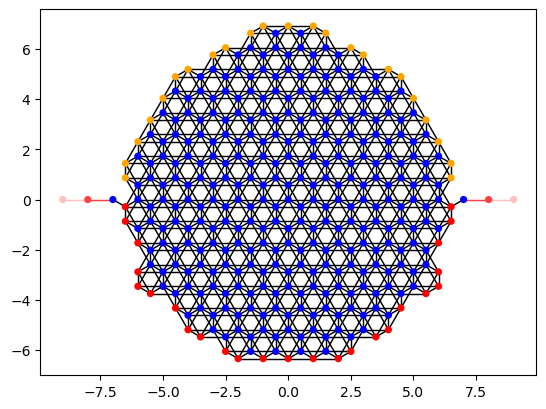

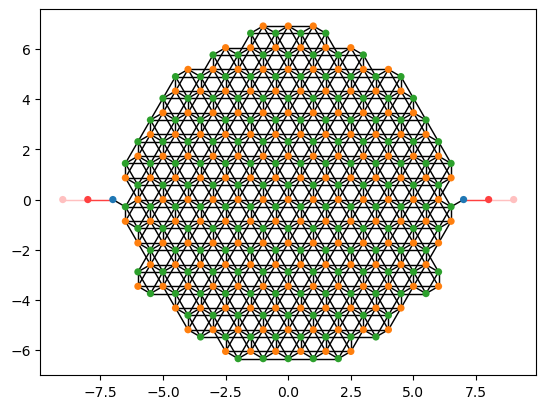

In [5]:

# Define the shape of the system
shapes = ["triangular-zz", "ribbon", "triangular-ac", "hexagon-zz", "hexagon-ac", "circle", "rectangle"]
shape = args.shape
if shape not in shapes:
    raise ValueError(f"Shape {shape} not recognized. Choose from {shapes}")

# Define the dimensions of the system

diminsions = SimpleNamespace(r=args.r, R=args.R, l=args.l, Lx=args.Lx, L=args.L, W=args.W, N_edge=args.N_edge)
# diminsions.N_edge = 50 # will have perfect transmission that descends slowly, but ascends later that I aim for

# Create the system
sys, edges = make_system(a, shape, diminsions)

edges_up = [s for s in edges if s.pos[1] > 0]
edges_down = [s for s in edges if s.pos[1] <= 0]

if shape == "triangular-zz":
    min_y = min(s.pos[1] for s in edges_up)
    edges_up = []
    edges_down = []
    for s in edges:
        if np.abs(s.pos[1] - min_y)<0.5: edges_down.append(s)
        else: edges_up.append(s)
elif shape == "rectangle":
    edges_up = []
    edges_down = []
    # for s in edges: # I changed this to consider all sites, not just edges
    for s in sys.sites():
        if s.pos[1]*args.L > s.pos[0]*args.W: edges_up.append(s)
        else: edges_down.append(s)


system_parameters = SimpleNamespace(t_2=args.t_2 + 1j * args.t_prime, m=args.m, disorder=args.disorder)


sys_with_leads_fin = add_leads(sys, shape, diminsions)

def color_edges(site):
    site = sys_with_leads_fin.sites[site]
    if site in edges_up:
        return 'orange'
    elif site in edges_down:
        return 'red'
    else:
        return 'blue'
kwant.plot(sys_with_leads_fin, site_size=0.25, show=False, site_color=color_edges)
kwant.plot(sys_with_leads_fin, site_size=0.25, show=True)
if shape == "triangular-zz": plt.hlines(min_y+0.5, -2, 12, color='red', lw=0.5)
plt.show()


In [6]:
import matplotlib.cm as cm
import matplotlib.colors as colors
e = args.energy - args.m/2 - args.t_2
wf = kwant.wave_function(sys_with_leads_fin, e, params=dict(param=system_parameters))
try:
    psi = wf(0)[0]
    psi_inv = wf(1)[0]
except IndexError:
    print("No wave function at the added site, check the energy.")
rho = kwant.operator.Density(sys_with_leads_fin)
density = rho(psi, params=dict(param=system_parameters))
density_inv = rho(psi_inv, params=dict(param=system_parameters))

J0 = kwant.operator.Current(sys_with_leads_fin)
current = J0(psi, params=dict(param=system_parameters))
current_inv = J0(psi_inv, params=dict(param=system_parameters))

# plot_the_densities = False
# if plot_the_densities:
#     fig, axs = plt.subplots(2, 2, figsize=(12, 10))
#     # 1. Local electron density
#     vmin, vmax = 0, 1
#     norm = colors.Normalize(vmin=vmin, vmax=vmax)
#     cmap = cm.Reds
#     kwant.plotter.map(sys_with_leads_fin, density, ax=axs[0, 0], cmap=cmap, vmin=vmin, vmax=vmax, show=False)
#     sm = cm.ScalarMappable(norm=norm, cmap=cmap)
#     sm.set_array([])
#     fig.colorbar(sm, ax=axs[0, 0])
#     axs[0, 0].set_title("Local electron density")
#     axs[0, 0].set_xlabel("x")
#     axs[0, 0].set_ylabel("y")


#     # 3. Local current
#     vmin, vmax = current.min(), current.max()
#     norm = colors.Normalize(vmin=vmin, vmax=vmax)
#     cmap = cm.seismic
#     kwant.plotter.current(sys_with_leads_fin, current, ax=axs[1, 0], cmap=cmap, show=False)
#     sm = cm.ScalarMappable(norm=norm, cmap=cmap)
#     sm.set_array([])
#     fig.colorbar(sm, ax=axs[1, 0])
#     axs[1, 0].set_title("Local current")
#     axs[1, 0].set_xlabel("x")
#     axs[1, 0].set_ylabel("y")


# fig, axs = plt.subplots(2, figsize=(12, 10))

# zcurrent_00 = J0(wf(0)[0], params=dict(param=system_parameters))
# vmin, vmax = zcurrent_00.min(), zcurrent_00.max()
# norm = colors.Normalize(vmin=vmin, vmax=vmax)
# cmap = cm.seismic
# kwant.plotter.current(sys_with_leads_fin, zcurrent_00, ax=axs[0], cmap=cmap, show=False)
# sm = cm.ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array([])
# fig.colorbar(sm, ax=axs[0])
# axs[0].set_title("Mode 0 Lead 0 Current")
# axs[0].set_xlabel("x")
# axs[0].set_ylabel("y")

# zcurrent_01 = J0(wf(1)[0], params=dict(param=system_parameters))
# vmin, vmax = zcurrent_01.min(), zcurrent_01.max()
# norm = colors.Normalize(vmin=vmin, vmax=vmax)
# cmap = cm.seismic
# kwant.plotter.current(sys_with_leads_fin, zcurrent_01, ax=axs[1], cmap=cmap, show=False)
# sm = cm.ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array([])
# fig.colorbar(sm, ax=axs[1])
# axs[1].set_title("Mode 0 Lead 1 Current")
# axs[1].set_xlabel("x")
# axs[1].set_ylabel("y")

# plt.tight_layout()
# plt.show()

In [7]:
energies = np.linspace(-1, 1.001, 251)
transmissions = []
conductance = []
for energy in energies:
    smatrix = kwant.smatrix(sys_with_leads_fin, energy, params=dict(param=system_parameters))
    T = smatrix.transmission(0, 1)
    transmissions.append(T)
    u_r, d_r, u_l, d_l = psi_up_dn(sys_with_leads_fin, energy, dict(param=system_parameters), edges_down=edges_down,edges_up=edges_up)
    conductance.append(T * np.abs((u_r + u_l)*(d_r + d_l)/(u_l*d_r - u_r*d_l)))


In [95]:
plt.figure(figsize=(7, 5))
plt.plot(energies, transmissions, label="T(0→1)")
plt.xlabel("Energy")
plt.ylabel("Transmission coefficient")
plt.title("Transmission vs Energy")
plt.legend()
plt.grid(True)
plt.show()
# plt.plot(energies, energies + 0.47)
plt.figure(figsize=(7, 5))
plt.plot(energies, conductance, label="Conductance", color='orange')
plt.xlabel("Energy")
plt.ylabel("Conductance")
plt.ylim(0, 5.0)
plt.title("Conductance vs Energy")
plt.legend()
plt.grid(True)
plt.show()

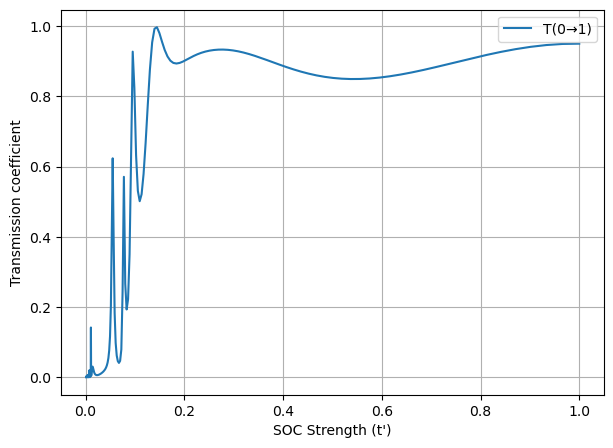

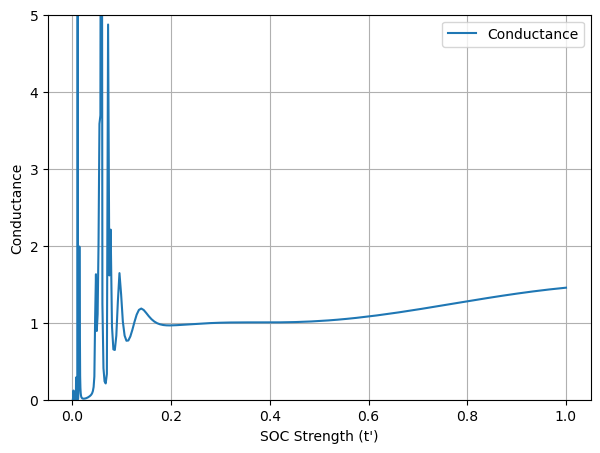

In [88]:
t_primes = 0.001*np.power(1/0.001, np.array(range(201))/200)
transmissions_soc = []
conductance_soc = []

for t_prime_ in t_primes:
    params = dict(param=SimpleNamespace(
        t_2=1j * t_prime_ + args.t_2,
        m=args.m,
        disorder=args.disorder,
    ))
    smatrix = kwant.smatrix(sys_with_leads_fin, args.energy-args.t_2 +args.m/2, params=params)
    T = smatrix.transmission(0, 1)
    transmissions_soc.append(T)
    # u_r, d_r, u_l, d_l = psi_up_dn(sys_with_leads_fin, 0.0, params, None, None)
    u_r, d_r, u_l, d_l = psi_up_dn(sys_with_leads_fin, args.energy-args.t_2 +args.m/2, params, edges_down=edges_down, edges_up=edges_up)
    conductance_soc.append(T * np.abs((u_r + u_l)*(d_r + d_l)/(u_l*d_r - u_r*d_l)))
# ul = 1, dr = 1, ur = 0, dl=0

plt.figure(figsize=(7, 5))
plt.plot(t_primes, transmissions_soc, label="T(0→1)")
plt.xlabel("SOC Strength (t')")
plt.ylabel("Transmission coefficient")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(t_primes, conductance_soc, label="Conductance")
plt.xlabel("SOC Strength (t')", fontsize=10)
plt.ylabel("Conductance")
plt.ylim(0, 5)
plt.legend()
plt.grid(True)
plt.show()

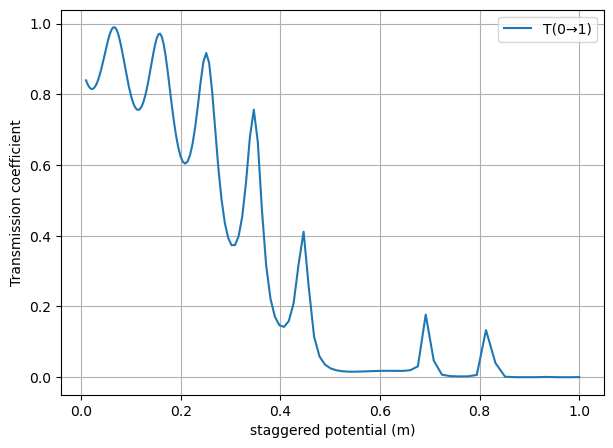

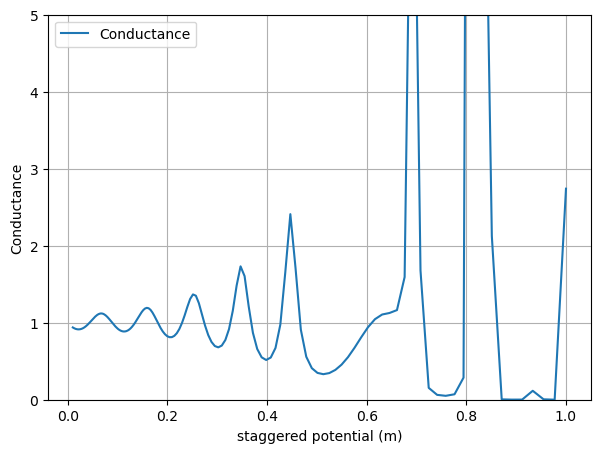

In [101]:
masses = 0.01*np.power(1/0.01, np.array(range(201))/200)
transmissions_m = []
conductance_m = []

for m_ in masses:
    params = dict(param=SimpleNamespace(
        t_2=1j * args.t_prime + args.t_2,
        m=m_,
        disorder=args.disorder,
    ))
    e = args.energy - args.t_2 - m_/2
    smatrix = kwant.smatrix(sys_with_leads_fin, e, params=params)
    T = smatrix.transmission(0, 1)
    transmissions_m.append(T)
    # u_r, d_r, u_l, d_l = psi_up_dn(sys_with_leads_fin, 0.0, params, None, None)
    u_r, d_r, u_l, d_l = psi_up_dn(sys_with_leads_fin, e, params, edges_down=edges_down, edges_up=edges_up)
    conductance_m.append(T * np.abs((u_r + u_l)*(d_r + d_l)/(u_l*d_r - u_r*d_l)))
# ul = 1, dr = 1, ur = 0, dl=0

plt.figure(figsize=(7, 5))
plt.plot(masses, transmissions_m, label="T(0→1)")
plt.xlabel("staggered potential (m)")
plt.ylabel("Transmission coefficient")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(masses, conductance_m, label="Conductance")
plt.xlabel("staggered potential (m)", fontsize=10)
plt.ylabel("Conductance")
plt.ylim(0, 5)
plt.legend()
plt.grid(True)
plt.show()

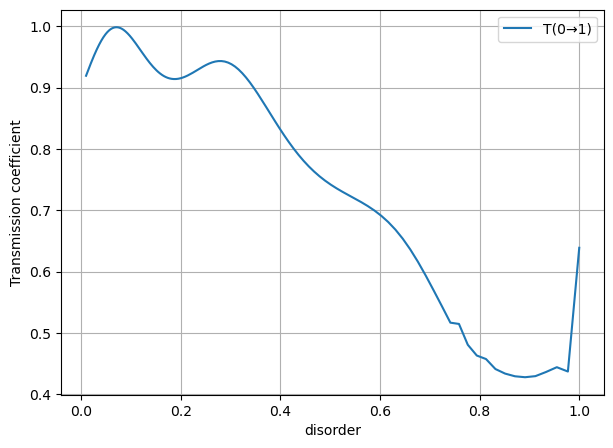

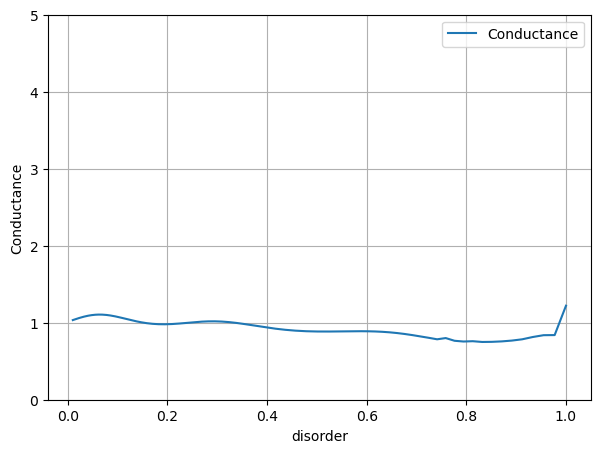

In [72]:
disorders = 0.01*np.power(1.0/0.01, np.array(range(201))/200)
transmissions_d = []
conductance_d = []

for d_ in disorders:
    params = dict(param=SimpleNamespace(
        t_2=1j * args.t_prime + args.t_2,
        m=args.m,
        disorder=d_,
    ))
    smatrix = kwant.smatrix(sys_with_leads_fin, args.energy, params=params)
    T = smatrix.transmission(0, 1)
    transmissions_d.append(T)
    # u_r, d_r, u_l, d_l = psi_up_dn(sys_with_leads_fin, 0.0, params, None, None)
    u_r, d_r, u_l, d_l = psi_up_dn(sys_with_leads_fin, args.energy, params, edges_down=edges_down, edges_up=edges_up)
    conductance_d.append(T * np.abs((u_r + u_l)*(d_r + d_l)/(u_l*d_r - u_r*d_l)))
# ul = 1, dr = 1, ur = 0, dl=0

plt.figure(figsize=(7, 5))
plt.plot(disorders, transmissions_d, label="T(0→1)")
plt.xlabel("disorder")
plt.ylabel("Transmission coefficient")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(disorders, conductance_d, label="Conductance")
plt.xlabel("disorder", fontsize=10)
plt.ylabel("Conductance")
plt.ylim(0, 5)
plt.legend()
plt.grid(True)
plt.show()

In [57]:
print(f"Maximum conductance: {max(conductance)}")
print(conductance)
# [0.008171124873275652, 0.008458268155578352, 0.008755501428876813, 0.009063179184960985, 0.00938166836312497, 0.009711348786522836, 0.010052613613718961, 0.010405869805957733, 0.010771538610712185, 0.011150056062080617, 0.011541873498606966, 0.011947458098971839, 0.012367293436455363, 0.012801880052465742, 0.013251736050229383, 0.013717397708607977, 0.014199420117537264, 0.014698377835280337, 0.015214865568260178, 0.015749498874474764, 0.016302914891084104, 0.0168757730869372, 0.017468756040867953, 0.018082570246963817, 0.018717946946866345, 0.019375642990822412, 0.020056441727949542, 0.020761153926682683, 0.021490618726410334, 0.022245704621315292, 0.023027310477248545, 0.023836366582750953, 0.024673835735510588, 0.025540714364327904, 0.02643803368927916, 0.02736686091944577, 0.02832830049043902, 0.029323495342340685, 0.030353628239216442, 0.03141992313142841, 0.03252364656165165, 0.033666109115905445, 0.034848666920463484, 0.036072723185988524, 0.03733972979958691, 0.038651188966245004, 0.04000865490015088, 0.04141373556726538, 0.042868094479795574, 0.044373452543350754, 0.04593158995775199, 0.047544348171869345, 0.04921363189314977, 0.0509414111523829, 0.052729723423318955, 0.05458067579839356, 0.05649644721899669, 0.05847929076110993, 0.06053153597508236, 0.06265559127872711, 0.06485394640267533, 0.06712917488617642, 0.06948393662127479, 0.07192098044295679, 0.07444314676219696, 0.077053370237881, 0.07975468248380757, 0.08255021480492251, 0.08544320095739663, 0.0884369799247917, 0.09153499870420899, 0.09474081508888128, 0.09805810044351544, 0.10149064245171954, 0.10504234782974789, 0.10871724498737642, 0.11251948661515887, 0.11645335218612247, 0.1205232503413765, 0.12473372114071389, 0.1290894381443183, 0.1335952103001447, 0.1382559835959844, 0.14307684244020408, 0.1480630107259488, 0.15321985252908393, 0.15855287238692142, 0.16406771509511736, 0.16977016495696562, 0.17566614440969963, 0.18176171194535687, 0.1880630592349325, 0.19457650735546006, 0.2013085020075042, 0.20826560760298837, 0.2154545000868814, 0.2228819583454772, 0.2305548540408198, 0.2384801396913205, 0.24666483480841253, 0.2551160098750602, 0.26384076793919164, 0.2728462235709081, 0.2821394789144554, 0.2917275965427085, 0.30161756880105517, 0.3118162833021151, 0.32233048421143, 0.33316672893868055, 0.34433133982823394, 0.3558303504169047, 0.3676694458082109, 0.3798538966929422, 0.392388486529197, 0.40527743138394073, 0.4185242919325006, 0.4321318771120465, 0.4461021389356544, 0.46043605799401904, 0.4751335192046927, 0.4901931774191819, 0.5056123125653125, 0.5213866740917454, 0.5375103145981036, 0.5539754126743552, 0.5707720851524684, 0.5878881891821635, 0.6053091147953604, 0.6230175689163778, 0.6409933521149007, 0.659213129783657, 0.6776501998559169, 0.6962742596594509, 0.7150511750269943, 0.7339427553491323, 0.7529065388528472, 0.7718955930116134, 0.7908583356255573, 0.8097383827417407, 0.8284744301931666, 0.84700017610505, 0.8652442922231872, 0.8831304523383736, 0.9005774263904166, 0.9174992490057479, 0.933805471231518, 0.9494015040459884, 0.9641890618246989, 0.9780667132905773, 0.9909305465415256, 1.0026749534880426, 1.0131935373981582, 1.0223801451772587, 1.0301300234374686, 1.0363410942583196, 1.0409153427247146, 1.0437603037802383, 1.0447906305969938, 1.0439297205306175, 1.041111367853312, 1.0362814049851075, 1.0293992861359056, 1.0204395595236433, 1.0093931671784697, 0.9962685054387549, 0.9810921753316691, 0.9639093508736052, 0.9447836956138758, 0.9237967639904361, 0.9010468344894996, 0.8766471360290448, 0.8507234467949166, 0.8234110648690015, 0.7948511709330159, 0.7651866234079996, 0.7345572438840602, 0.7030946641498813, 0.6709168146470734, 0.6381221376714867, 0.6047836080810175, 0.5709426417608978, 0.536602970914358, 0.5017245696715493, 0.4662177285336669, 0.42993740696847776, 0.39267804461574496, 0.3541690858324433, 0.31407156906064987, 0.271976245483623, 0.22740380616604433, 0.1798078880852578, 0.1285815594600991, 0.07306790459144274, 0.012575083760068457, 0.053604211661648, 0.12616967173466603, 0.2057882824193612, 0.29306981755325356, 0.38854629110565425, 0.4926591641966531, 0.6057578682802713]
arr1 = np.array([0.008171124873275652, 0.008458268155578352, 0.008755501428876813, 0.009063179184960985, 0.00938166836312497, 0.009711348786522836, 0.010052613613718961, 0.010405869805957733, 0.010771538610712185, 0.011150056062080617, 0.011541873498606966, 0.011947458098971839, 0.012367293436455363, 0.012801880052465742, 0.013251736050229383, 0.013717397708607977, 0.014199420117537264, 0.014698377835280337, 0.015214865568260178, 0.015749498874474764, 0.016302914891084104, 0.0168757730869372, 0.017468756040867953, 0.018082570246963817, 0.018717946946866345, 0.019375642990822412, 0.020056441727949542, 0.020761153926682683, 0.021490618726410334, 0.022245704621315292, 0.023027310477248545, 0.023836366582750953, 0.024673835735510588, 0.025540714364327904, 0.02643803368927916, 0.02736686091944577, 0.02832830049043902, 0.029323495342340685, 0.030353628239216442, 0.03141992313142841, 0.03252364656165165, 0.033666109115905445, 0.034848666920463484, 0.036072723185988524, 0.03733972979958691, 0.038651188966245004, 0.04000865490015088, 0.04141373556726538, 0.042868094479795574, 0.044373452543350754, 0.04593158995775199, 0.047544348171869345, 0.04921363189314977, 0.0509414111523829, 0.052729723423318955, 0.05458067579839356, 0.05649644721899669, 0.05847929076110993, 0.06053153597508236, 0.06265559127872711, 0.06485394640267533, 0.06712917488617642, 0.06948393662127479, 0.07192098044295679, 0.07444314676219696, 0.077053370237881, 0.07975468248380757, 0.08255021480492251, 0.08544320095739663, 0.0884369799247917, 0.09153499870420899, 0.09474081508888128, 0.09805810044351544, 0.10149064245171954, 0.10504234782974789, 0.10871724498737642, 0.11251948661515887, 0.11645335218612247, 0.1205232503413765, 0.12473372114071389, 0.1290894381443183, 0.1335952103001447, 0.1382559835959844, 0.14307684244020408, 0.1480630107259488, 0.15321985252908393, 0.15855287238692142, 0.16406771509511736, 0.16977016495696562, 0.17566614440969963, 0.18176171194535687, 0.1880630592349325, 0.19457650735546006, 0.2013085020075042, 0.20826560760298837, 0.2154545000868814, 0.2228819583454772, 0.2305548540408198, 0.2384801396913205, 0.24666483480841253, 0.2551160098750602, 0.26384076793919164, 0.2728462235709081, 0.2821394789144554, 0.2917275965427085, 0.30161756880105517, 0.3118162833021151, 0.32233048421143, 0.33316672893868055, 0.34433133982823394, 0.3558303504169047, 0.3676694458082109, 0.3798538966929422, 0.392388486529197, 0.40527743138394073, 0.4185242919325006, 0.4321318771120465, 0.4461021389356544, 0.46043605799401904, 0.4751335192046927, 0.4901931774191819, 0.5056123125653125, 0.5213866740917454, 0.5375103145981036, 0.5539754126743552, 0.5707720851524684, 0.5878881891821635, 0.6053091147953604, 0.6230175689163778, 0.6409933521149007, 0.659213129783657, 0.6776501998559169, 0.6962742596594509, 0.7150511750269943, 0.7339427553491323, 0.7529065388528472, 0.7718955930116134, 0.7908583356255573, 0.8097383827417407, 0.8284744301931666, 0.84700017610505, 0.8652442922231872, 0.8831304523383736, 0.9005774263904166, 0.9174992490057479, 0.933805471231518, 0.9494015040459884, 0.9641890618246989, 0.9780667132905773, 0.9909305465415256, 1.0026749534880426, 1.0131935373981582, 1.0223801451772587, 1.0301300234374686, 1.0363410942583196, 1.0409153427247146, 1.0437603037802383, 1.0447906305969938, 1.0439297205306175, 1.041111367853312, 1.0362814049851075, 1.0293992861359056, 1.0204395595236433, 1.0093931671784697, 0.9962685054387549, 0.9810921753316691, 0.9639093508736052, 0.9447836956138758, 0.9237967639904361, 0.9010468344894996, 0.8766471360290448, 0.8507234467949166, 0.8234110648690015, 0.7948511709330159, 0.7651866234079996, 0.7345572438840602, 0.7030946641498813, 0.6709168146470734, 0.6381221376714867, 0.6047836080810175, 0.5709426417608978, 0.536602970914358, 0.5017245696715493, 0.4662177285336669, 0.42993740696847776, 0.39267804461574496, 0.3541690858324433, 0.31407156906064987, 0.271976245483623, 0.22740380616604433, 0.1798078880852578, 0.1285815594600991, 0.07306790459144274, 0.012575083760068457, 0.053604211661648, 0.12616967173466603, 0.2057882824193612, 0.29306981755325356, 0.38854629110565425, 0.4926591641966531, 0.6057578682802713])
arr2 = np.array([112.36119843990032, 108.54678959966134, 104.86188192536302, 101.30207929778179, 97.86313467718018, 94.54094525240573, 91.33154741884282, 88.23111239652724, 85.23594105553192, 82.34246009278284, 79.54721746999998, 76.84687828088398, 74.2382209356925, 71.7181331936502, 69.28360844750097, 66.93174220941748, 64.65972860129501, 62.464856996955824, 60.34450883138056, 58.29615440520016, 56.31734996466555, 54.40573469141934, 52.5590279431449, 50.77502651847063, 49.0516020169428, 47.38669831939236, 45.77832911495794, 44.22457555056702, 42.72358392331266, 41.27356348428864, 39.87278429133935, 38.5195751515559, 37.212321624545254, 35.94946409731582, 34.729495923215026, 33.55096162449677, 32.412455156076284, 31.312618227811264, 30.250138684101756, 29.223748938434948, 28.232224461124673, 27.27438231830098, 26.349079760660757, 25.455212860229928, 24.59171519309298, 23.757556567323345, 22.951741793827082, 22.17330949900163, 21.42133097787223, 20.69490908601518, 19.993177169254782, 19.315298029790597, 18.66046292723259, 18.027890613893074, 17.416826402624114, 16.826541266459895, 16.256330968920196, 15.705515223819036, 15.173436883568073, 14.659461155272195, 14.162974843405616, 13.683385618167618, 13.22012130889714, 12.772629221439564, 12.340375478761915, 11.922844384012965, 11.519537805339981, 11.129974581564252, 10.75368994818367, 10.390234982900509, 10.03917607006705, 9.700094383398753, 9.372585386302505, 9.056258349326141, 8.750735884009229, 8.455653492663762, 8.17065913366283, 7.895412801334068, 7.629586120532395, 7.372861954861065, 7.124934028433767, 6.8855065604848935, 6.654293912675313, 6.431020248362251, 6.215419203672328, 6.00723356978018, 5.806214986272836, 5.612123644977917, 5.42472800400599, 5.243804511770573, 5.069137340466012, 4.900518128846829, 4.737745733932856, 4.580625991324157, 4.4289714839202565, 4.282601318712958, 4.14134091141382, 4.005021778645916, 3.873481337500149, 3.7465627121552427, 3.62411454742347, 3.5059908289390496, 3.392050709816596, 3.282158343577061, 3.176182723169144, 3.0739975258798236, 2.9754809640002704, 2.8805156410616264, 2.788988413506106, 2.7007902576522027, 2.615816141809214, 2.5339649034569507, 2.45513913133314, 2.3792450523728306, 2.306192423389443, 2.2358944274332266, 2.168267574765107, 2.1032316083990827, 2.040709414184592, 1.9806269354157486, 1.922913091972831, 1.8674997040207413, 1.8143214203167843, 1.7633156511961792, 1.7144225063405873, 1.667584737456536, 1.6227476860315835, 1.5798592363661077, 1.5388697741246415, 1.4997321506922014, 1.4624016536740045, 1.4268359839245726, 1.39299523956172, 1.360841907479011, 1.330340862943071, 1.301459377944788, 1.2741671390528766, 1.248436275617469, 1.2242413992701853, 1.201559655778883, 1.1803707904402216, 1.160657228324384, 1.1424041708415156, 1.1255997102578663, 1.1102349639868476, 1.096304230684477, 1.0838051704281473, 1.0727390115390325, 1.0631107869375351, 1.0549296033117102, 1.0482089468397084, 1.0429670297586058, 1.0392271827279462, 1.0370182987249734, 1.0363753351462996, 1.037339881910211, 1.039960804674982, 1.044294973842842, 1.0504080918206133, 1.0583756330757432, 1.0682839138504336, 1.0802313109543653, 1.0943296517794046, 1.1107058004477328, 1.1295034676163098, 1.1508852736019355, 1.1750350956929736, 1.2021607300980923, 1.2324968959932308, 1.2663086022493673, 1.3038948848799403, 1.345592902692792, 1.3917823470240644, 1.4428900749046167, 1.4993948087324522, 1.5618316535837902, 1.6307960585498946, 1.7069466824716815, 1.791006407242361, 1.8837604620597357, 1.986050266948496, 2.098761160310323, 2.222801631830897, 2.3590710346276316, 2.5084120138612587, 2.671543118760653, 2.848966395869599, 3.0408444667516026, 3.2468421681136985, 3.465930084713951, 3.6961524189894424, 3.934371108424786, 4.176013361148174, 4.414871320201511, 4.643028301863838, 4.851009126803526, 5.028259094785552, 5.164028273045925, 5.248657586452824, 5.275129051958195, 5.240584847774118])

Maximum conductance: 1.0375190559362784
[0.008145092015640442, 0.008431320402921648, 0.008727606624989864, 0.00903430404304859, 0.009351778426091976, 0.009680408385712777, 0.010020585826281292, 0.010372716410692831, 0.01073722004241928, 0.011114531364123664, 0.011505100273928232, 0.011909392459496335, 0.01232788995029943, 0.012761091689861148, 0.013209514126901332, 0.013673691827694187, 0.014154178109102102, 0.014651545693689184, 0.015166387387604646, 0.015699316781460554, 0.01625096897551002, 0.016822001329865183, 0.017413094240198344, 0.018024951940154854, 0.018658303331149952, 0.019313902840466742, 0.01999253130846601, 0.020694996906183143, 0.0214221360835258, 0.022174814549943703, 0.022953928287877158, 0.023760404600272223, 0.02459520319301061, 0.02545931729360667, 0.026353774806877114, 0.027279639504573416, 0.028238012278609056, 0.02923003237503299, 0.030256878757258587, 0.03131977140460201, 0.032419972791526946, 0.03355878926056756, 0.03473757254249428, 0.035957721303729484, 0.03

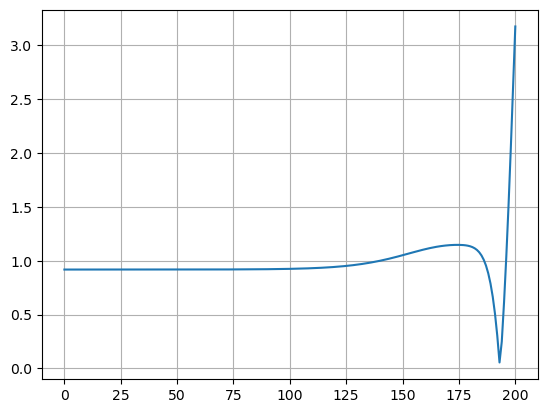

In [58]:
plt.plot(arr1* arr2)
plt.grid()